# Nonlinear Damped Pendulum

$$
mL\dfrac{d^2 \theta}{d t^2} + \beta L \dfrac{d \theta}{d t} + mg\sin(\theta) = G(t),
$$

or

$$
\dfrac{d^2 \theta}{d t^2} + b \dfrac{d \theta}{d t} + \omega_0^2\sin(\theta) = F(t)~,
$$

where
$$
\omega_0^2 = \frac{g}{L}, \quad b = \frac{\beta}{m}, \quad F(t) = F\cos(\Omega t) 
$$

with the initial conditions
$$
\theta(0) = \frac{\pi}{4}~~,~~\dot{\theta}(0) = 0~.

In [189]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.integrate import odeint

## Generate training data

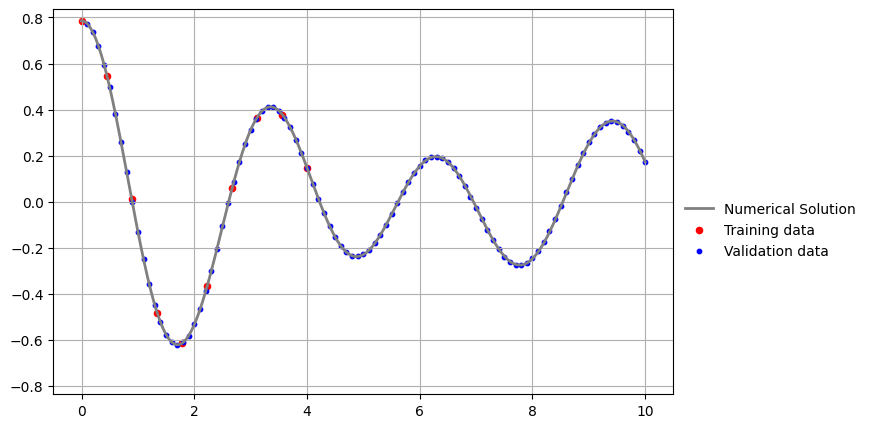

In [190]:
# Parameters and initial conditions
# w0^2 = g/L, 

w0 = 2
b  = 0.2
F  = 0.3
W  = np.sqrt(2)

X0 = [np.pi/4, 0]

# time domain
ti = 0
tf = 10
N  = 1000

t = torch.linspace(ti, tf, N).view(-1,1)

# Numerical Solution
def ODE(X, t):
    dXdt = [X[1], -(w0**2)*np.sin(X[0]) - b*X[1] + F*np.cos(W*t)]
    return dXdt

solution = odeint(ODE, X0, t.numpy().flatten())
x        = torch.from_numpy(solution[:,0]).view(-1,1)
dx       = torch.from_numpy(solution[:,1]).view(-1,1)
x_max    = torch.max(torch.abs(x))

solution.dtype = np.double

# Pick points for training
N_training = 10
t_data  = torch.linspace(ti, tf*0.4, N_training).view(-1,1)
x_data  = x[torch.searchsorted(t.flatten(), t_data.flatten())]
dx_data = dx[torch.searchsorted(t.flatten(), t_data.flatten())]

# Pick a few points for validation
N_validation = 100
t_val  = torch.linspace(ti+0.1, tf, N_validation).view(-1,1)
x_val  = x[torch.searchsorted(t.flatten(), t_val.flatten())]
dx_val = dx[torch.searchsorted(t.flatten(), t_val.flatten())]

plt.figure(figsize=(8,5))

plt.plot(t, solution[:,0], label="Numerical Solution", color='grey', lw=2, alpha=1, linestyle='-')
plt.scatter(t_data, x_data, color="red", label="Training data", s=20)
plt.scatter(t_val, x_val, color="blue", label="Validation data", s=10)
plt.ylim(-x_max-.05, x_max+0.05)
plt.legend(frameon=False, loc=(1.01, 0.34))
plt.grid()
plt.show()

In [191]:
# Plotting Function

def plot_result(epochs, i, t, x, t_data, x_data, u, training_loss, validation_loss, tp=None, vt=None, vp=None):
    """
    Plots pretty plots
    """
    plt.figure(figsize=(10,9))
    plt.subplot(2,1,1)
    
    plt.plot(t, x,  color="grey", linewidth=2, alpha=1, label="Numerical solution")
    plt.plot(t, u, color="black", linewidth=3, alpha=0.8, label="PINN prediction")
    plt.scatter(t_data, x_data, s=20, color="red", alpha=0.6, label='Initial value')
    if vt is not None:
        plt.scatter(vt, vp, s=10, color="blue", alpha=0.6, label='Validation data')
    if tp is not None:
        plt.scatter(tp, -0*torch.ones_like(tp), s=10, color="green", alpha=0.6, label='Physics loss training locations')
        
    l = plt.legend(loc=(1.01, 0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(ti-0.1, tf+0.1)
    plt.ylim(-x_max*(1+0.1), x_max*(1+0.1))
    plt.title("Nonlinear Damped Pendulum PINN \n Training step: %i"%(i),color="k")
    plt.xlabel("Time (s)", fontsize="small", color="k")
    plt.ylabel("Angle", fontsize="small", color="k")
    plt.axis("on")

    plt.subplot(2,1,2)
    plt.plot(np.arange(i+1), training_loss, label='Training Loss', color='red', linewidth=0.7, alpha=1, linestyle='-')
    plt.plot(np.arange(i+1), validation_loss, label='validation Loss',color='blue', linewidth=1, alpha=0.9)

    plt.title("Loss vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.yscale('log')
    plt.ylim(1e-7, 1e2)
    plt.xlim(0, epochs*1.01)
    plt.legend(loc=(1.01, 0.34), frameon=False, fontsize="large")
    plt.grid()



# Gif Saving function
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

## PINN

In [192]:
# Define Neural Network Structure

class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS, ti, tf):
        super().__init__()
        activation = nn.Tanh
        
        self.fcs = nn.Sequential(*[nn.Linear(N_INPUT, N_HIDDEN), activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[nn.Linear(N_HIDDEN, N_HIDDEN), activation()]) for _ in range(N_LAYERS-1)
                        ])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        self.scale = lambda T : (T - ti)/(tf-ti)
        
    def forward(self, x):
        x = self.scale(x)
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [193]:
def PINN_model(name, epochs,
               ti, tf,  
               learning_rate, lr_decay, 
               w1, w2,
               time_data, value_data, derivative_data,
               time_physics,
               time_validation, value_val, derivative_val,
               save_gif=False):
    """
    epochs: Maximum number of training steps (epochs)
    learning_rate: Initial learning of the optimizer 1e-2 is a large value, good when using a scheduler. 1e-4 is a small value, good if not using a scheduler.
    lr_decay: Learning rate decay factor. 0.7 is a good value
    w1: Weight for the derivative loss function
    w2: Weight for the physics loss function
    time_data: Training data time points
    value_data: Training data for solution
    derivative_data: Training data for the derivative of the solution
    time_physics: Physics training data time points
    time_validation: Validation data time points
    value_val: Validation data for solution
    derivative_val: Validation data for the derivative of the solution
    save_gif: If True, saves a GIF of the training process
    name: Name of the model, used for saving files
    
    Returns:
        training_loss: List of training losses at each epoch
        validation_loss: List of validation losses at each epoch
    
    Outputs:
        Saves a GIF of the training process if save_gif is True
        Saves the trained model to a file
        Shows Plots every 10_000 epochs and on the last epoch
    """
    PINN = FCN(1, 1, 32, 3, ti, tf)
    optimizer = torch.optim.Adam(PINN.parameters(), lr = learning_rate)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=lr_decay)
    
    files           = []
    training_loss   = []
    validation_loss = []
    
    for i in range(epochs):
        # ===
        # Training
        # ===
        
        PINN.train()
        optimizer.zero_grad()
        
        # Training loss for data
        u = PINN(time_data)
        loss_value = torch.mean((u - value_data)**2)

        # Derivative training loss
        du = torch.autograd.grad(u, time_data, torch.ones_like(u), create_graph=True)[0]
        loss_derivative = torch.mean((du - derivative_data)**2)
        
        # Physics loss
        p   = PINN(time_physics)
        dp  = torch.autograd.grad(p, time_physics, torch.ones_like(p), create_graph=True)[0]
        d2p = torch.autograd.grad(dp,  time_physics, torch.ones_like(dp),  create_graph=True)[0]
        ODE = d2p + b*dp + (w0**2)*torch.sin(p) - F*torch.cos(W*time_physics)
        loss_ODE = torch.mean(ODE**2)
        
        # Total loss
        loss = loss_value + w1*loss_derivative + w2*loss_ODE
        training_loss.append(loss.detach())
        
        # Backpropagation
        loss.backward()
        
        # Update parameters
        optimizer.step()

        # Update learning rate
        if (i+1) % 2000 == 0: scheduler.step()
        
        # ===
        # Validation
        # ===
        
        PINN.eval()

        u_val = PINN(time_validation)
        loss_value_val = torch.mean((u_val - value_val)**2)
        
        du_val = torch.autograd.grad(u_val, time_validation, torch.ones_like(u_val), create_graph=True)[0]
        loss_derivative_val = torch.mean((du_val - derivative_val)**2)
        
        d2u_val = torch.autograd.grad(du_val,  time_validation, torch.ones_like(du_val),  create_graph=True)[0]
        physics_val = d2u_val + b*derivative_val + (w0**2)*torch.sin(value_val) - F*torch.cos(W*time_validation)
        loss_ODE_val = torch.mean(physics_val**2)
        
        loss_val = loss_value_val + w1*loss_derivative_val + w2*loss_ODE_val
        validation_loss.append(loss_val.detach())
        
        # ===
        # Plotting
        # ===
        
        if (i % 1_000) == 0: 
            v  = PINN(t).detach()
            tp = time_physics.detach()
            
            plot_result(epochs, i, t, x, t_data, x_data, v, training_loss, validation_loss, tp, t_val, x_val)
            
            file = f"plots/PINN_{name}_{i}.png"
            plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
            files.append(file)
            
            if (i+1 == epochs):
                file_last = f"PINN_{name}.png"
                plt.savefig(file_last, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white") 
            elif (i % 10_000) == 0:
                plt.show()
            else: plt.close("all")
        
    # ===
    # Saving GIF
    # ===
    
    if save_gif: save_gif_PIL(f"gifs/PINN_{name}.gif", files, fps=15, loop=0)
    torch.save(PINN.state_dict(), f"models/PINN_{name}.pth")
    return training_loss, validation_loss

In [194]:
# Define the sample locations for physics loss
N_phys = 200
t_physics = torch.tensor(
    [0.5*(tf+ti) + 0.5*(tf-ti)*np.cos((i+0.5)/N_phys * np.pi) for i in range(N_phys)], dtype=torch.float32
    ).view(-1,1).requires_grad_(True)
# t_physics  = torch.linspace(ti + 0.1, tf, 200).view(-1,1).requires_grad_(True)

# Define the samle locations for training data
t_training  = t_data.clone().requires_grad_(True)

# Define the sample locations for validation
t_validation = t_val.clone().requires_grad_(True)

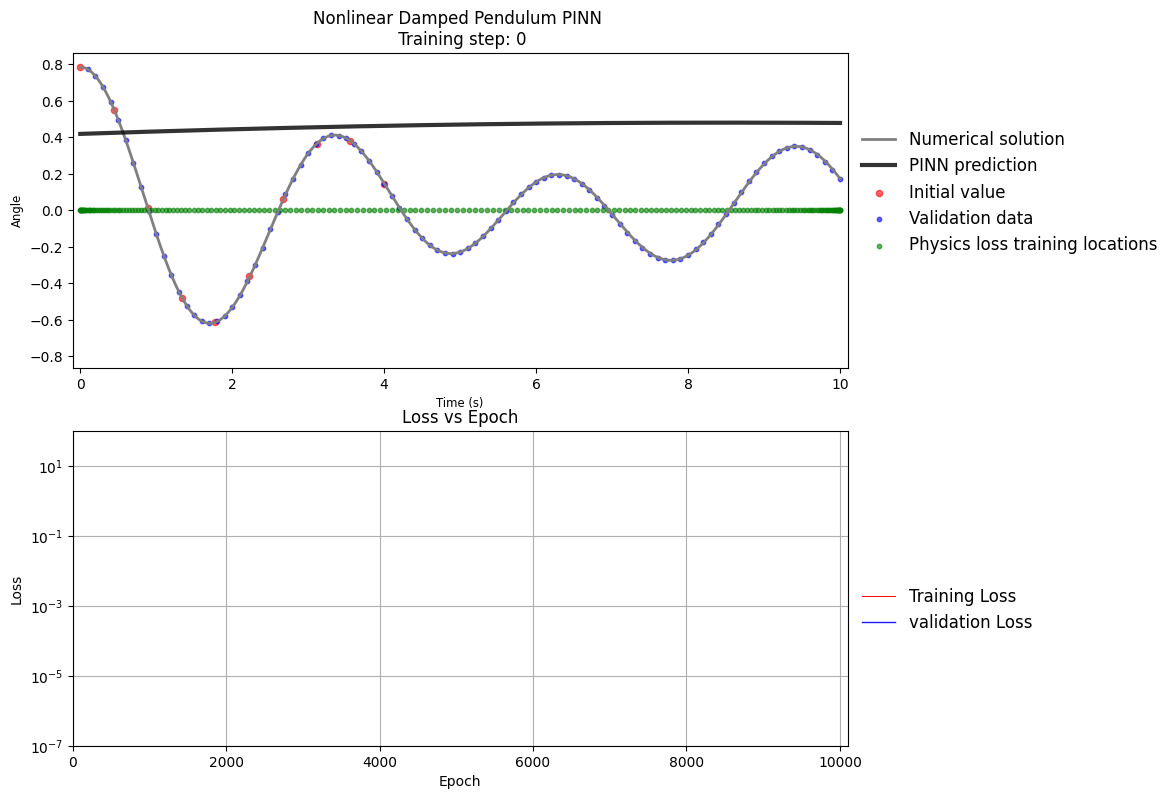

KeyboardInterrupt: 

In [ ]:
torch.manual_seed(123)
PINN1 = PINN_model(name="Pendulum", epochs=10_000+1,
                ti=ti, tf=tf,
                learning_rate=1e-2, lr_decay=0.7, 
                w1=1e0, w2=1e0,
                time_data=t_training, value_data=x_data, derivative_data=dx_data,
                time_physics=t_physics,
                time_validation=t_validation, value_val=x_val, derivative_val=dx_val,
                save_gif=True)